In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os
import logging
from scipy.integrate import odeint
from sabcom.differential_equation_model import differential_equations_model
from sabcom.estimation import constrNM, confidence_interval

# Analyse first wave


In [2]:
with open('cape_town/first_waveparameters.json', 'r') as f:
    params1 = json.loads(f.read())

In [3]:
sim_data1 = pd.read_csv('output_data/first_wave/seed1quantities_state_time.csv')

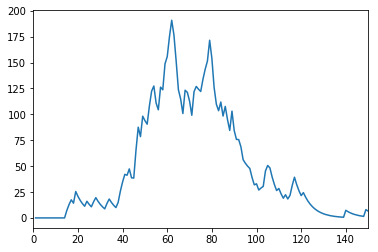

In [4]:
sim_dead_curve = sim_data1['d'] * (params1['empirical_population'] / params1['number_of_agents'])
sim_dead_curve.diff().ewm(span=10).mean().plot()

# Simulate second wave

3. write script to simulate multiple runs second wave
4. write script to plot graph with fit first and second waves

In [5]:
with open('cape_town/second_waveparameters.json', 'r') as f:
    params2 = json.loads(f.read())

In [6]:
sim_data2 = pd.read_csv('output_data/second_wave/seed1quantities_state_time.csv')

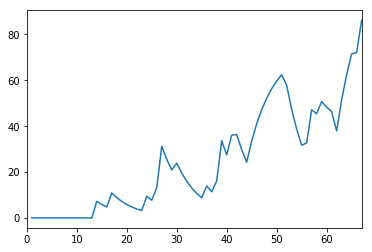

In [7]:
sim_dead_curve2 = sim_data2['d'] * (params2['empirical_population'] / params2['number_of_agents'])
sim_dead_curve2.diff().ewm(span=10).mean().plot()

# Plot both

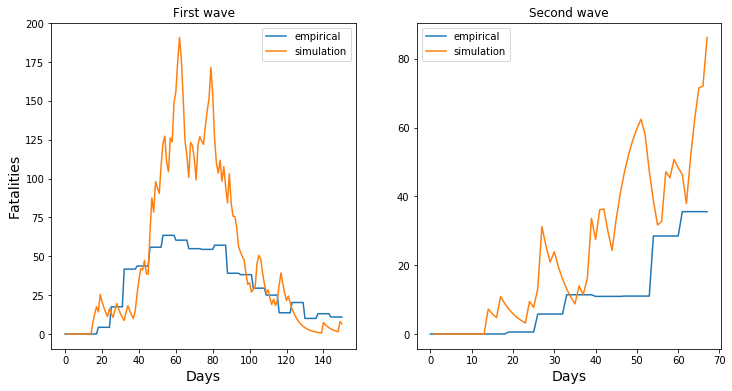

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(range(len(params1['empirical_fatalities'])), params1['empirical_fatalities'], label='empirical')
ax1.plot(sim_dead_curve.index, sim_dead_curve.diff().ewm(span=10).mean(), label='simulation')
ax1.set_ylabel('Fatalities', fontsize='14')
ax1.set_xlabel('Days', fontsize='14')
ax1.set_title('First wave')

ax1.legend()

ax2.plot(range(len(params2['empirical_fatalities'])), params2['empirical_fatalities'], label='empirical')
ax2.plot(sim_dead_curve2.index, sim_dead_curve2.diff().ewm(span=10).mean(), label='simulation')
ax2.set_xlabel('Days', fontsize='14')
ax2.set_title('Second wave')

ax2.legend()

fig.savefig('graphs.png')

In [1]:
# ! sabcom simulate -s 1 -i cape_town -o output_data/cape_town -sc lockdown -d csv-light -scf cape_town/second_waveparameters.json -init networks_for_secondwave

# Plot fatalities for no-intervention

In [9]:
with open('cape_town/first_strainparameters.json', 'r') as f:
    params_strain1 = json.loads(f.read())

In [10]:
sim_data_strain1 = pd.read_csv('output_data/first_strain/seed1quantities_state_time.csv')

In [11]:
sim_data_strain2 = pd.read_csv('output_data/second_strain/seed1quantities_state_time.csv')

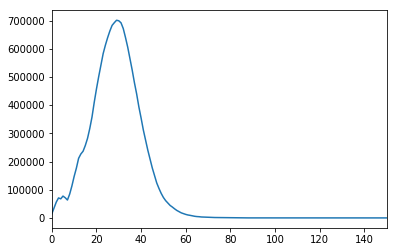

In [16]:
# sim_dead_curve_strain1 = sim_data_strain1['d'] * (params_strain1['empirical_population'] / params_strain1['number_of_agents'])
# sim_dead_curve_strain1.diff().ewm(span=10).mean().plot()

sim_exp_curve_strain1 = sim_data_strain1['e'] * (params_strain1['empirical_population'] / params_strain1['number_of_agents'])
sim_exp_curve_strain1.plot()#.diff().ewm(span=10).mean().plot()

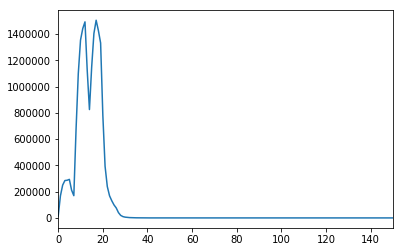

In [17]:
sim_exp_curve_strain2 = sim_data_strain2['e'] * (params_strain1['empirical_population'] / params_strain1['number_of_agents'])
sim_exp_curve_strain2.plot()#.diff().ewm(span=10).mean().plot()

In [18]:
# fig, ax1 = plt.subplots(1, 1, figsize=(12,6))

# ax1.plot(range(len(params_strain1['empirical_fatalities'])), params_strain1['empirical_fatalities'], label='empirical')
# ax1.plot(sim_dead_curve_strain1.index, sim_dead_curve_strain1.diff().ewm(span=10).mean(), label='no-int-strain-1')
# ax1.set_ylabel('Fatalities', fontsize='14')
# ax1.set_xlabel('Days', fontsize='14')
# ax1.set_title('First wave')

# ax1.legend()

# #ax2.plot(range(len(params2['empirical_fatalities'])), params2['empirical_fatalities'], label='empirical')
# ax1.plot(sim_dead_curve_strain2.index, sim_dead_curve_strain2.diff().ewm(span=10).mean(), label='no-int-strain-2')
# #ax2.set_xlabel('Days', fontsize='14')
# #ax2.set_title('Second wave')

# ax1.legend()

# fig.savefig('graphs_strain1&2_no_intervention.png')

# Estimate R0 for strain 1 and for strain 2

In [19]:
def demodel(**kwargs):
    input_folder_path = kwargs.get('input_folder_path')
    output_folder_path = kwargs.get('output_folder_path')

    parameters_path = os.path.join(input_folder_path, 'first_strainparameters.json')

    if not os.path.exists(parameters_path):
        click.echo(parameters_path + ' not found', err=True)
        click.echo('No parameter file found')
        return

    with open(parameters_path) as json_file:
        parameters = json.load(json_file)
        for param in parameters:
            logging.debug('Parameter {} is {}'.format(param, parameters[param]))
            
    # optionally change parameters using a config file NEW
    if os.path.exists('config_sensitivity_ode.json'):
        with open('config_sensitivity_ode.json') as json_file:
            config_file = json.load(json_file)

            for param in config_file:
                if param in ["probability_critical_multiplier", "probability_to_die_multiplier"]:
                    multiplier = config_file[param] 
                    parameters[param[:-11]] = {key: parameters[param[:-11]][key] * multiplier for key in parameters[param[:-11]]}
                    logging.debug('After config parameter {} is {}'.format(param[:-11], parameters[param[:-11]]))
                else:
                    parameters[param] = config_file[param]
                    logging.debug('After config parameter {} is {}'.format(param, parameters[param]))

    # arguments = city
    initial_infected = parameters['total_initial_infections']
    T = len(parameters['empirical_fatalities']) # for estimation

    # Set Covid-19 Parameters:
    # basic reproduction number
    r_zero = kwargs.get('r_zero') #initial_recovered
    exposed_days = float(parameters["exposed_days"])
    asymptomatic_days = float(parameters["asymptom_days"])
    symptomatic_days = float(parameters["symptom_days"])
    critical_days = float(parameters["critical_days"])

    # compartment exit rates
    exit_rate_exposed = 1.0 / exposed_days
    exit_rate_asymptomatic = 1.0 / asymptomatic_days
    exit_rate_symptomatic = 1.0 / symptomatic_days
    exit_rate_critical = 1.0 / critical_days

    probability_symptomatic = parameters["probability_symptomatic"]
    # Probability to become critically ill if symptomatic (source: Verity et al.2020)
    probability_critical = np.array([x for x in parameters["probability_critical"].values()])
    # Probability to die if critically ill (source: Silal et al.2020)
    probability_to_die = np.array([x for x in parameters["probability_critical"].values()])

    # Total population:
    district_population = pd.read_csv(os.path.join(input_folder_path, 'f_population.csv'), index_col=0)
    district_population = district_population.values
    population = parameters["empirical_population"] #district_population.sum()  # sum over wards to obtain city population

    # Set city specific parameters
    hospital_capacity = int(round(parameters["health_system_capacity"] * population))

    # Population by age group (N_age(i) is the population of age group i)
    ward_age_distribution = pd.read_csv(os.path.join(input_folder_path, 'f_age_distribution.csv'),
                                        index_col=0)  # the datafile contains ward level fractions in each age group
    N_age = ward_age_distribution * district_population  # convert to number of people in age group per ward
    N_age = N_age.sum()  # sum over wards
    N_age = N_age.values  # store city level population sizes of each age group

    # Load raw contact matrices
    household_contacts = pd.read_csv(os.path.join(input_folder_path, 'f_household_contacts.csv'), index_col=0)
    other_contacts = pd.read_csv(os.path.join(input_folder_path, 'f_nonhousehold_contacts.csv'), index_col=0)
    contact_matrix = household_contacts + other_contacts
    contact_matrix = contact_matrix.values

    # Replicate last row and column to change the 8 category contact matrix to a 9 category matrix
    contact_matrix = np.vstack((contact_matrix, contact_matrix[7, 0:8]))
    C_last_column = contact_matrix[0:9, 7]
    C_last_column.shape = (9, 1)
    contact_matrix = np.hstack((contact_matrix, C_last_column))

    # Apply reciprocity correction (see Towers and Feng (2012))
    # C_corrected(j,k) = (C(j,k)*N(j) + C(k,j)*N(k))/(2*N(j))
    for j in range(contact_matrix.shape[0]):
        for k in range(contact_matrix.shape[0]):
            contact_matrix[j, k] = (contact_matrix[j, k] * N_age[j] + contact_matrix[k, j] * N_age[k]) / (2 * N_age[j])

    # Scale contact matrix by population size
    # - each column is normalized by the population of that age group: X(i,j)=C(i,j)/N_age(j)
    N_age_row_vector = np.array(N_age)
    N_age_row_vector.shape = (1, 9)
    contact_probability_matrix = np.divide(contact_matrix,
                                           N_age_row_vector)  # X(i,j)=C(i,j)/N_age(j) - entries now measure fraction of each age group contacted on average per day

    # Compute infection_rate from R0, exit_rate_asymptomatic, e_S and dominant eigenvalue of matrix X(i,j)*N_age(i)
    N_age_column_vector = np.array(N_age)
    N_age_column_vector.shape = (9, 1)
    eigen_values, eigen_vectors = np.linalg.eig(np.multiply(contact_probability_matrix, N_age_column_vector))
    dom_eig_val = max(eigen_values)

    infection_rate = (((1 - probability_symptomatic) * exit_rate_asymptomatic + probability_symptomatic * exit_rate_symptomatic) * r_zero) / dom_eig_val
    #click.echo('infection rate (beta) is {}'.format(round(infection_rate, 4)))

    # Set initial conditions
    # spread initial infections (exposed individuals) across age groups equally
    initial_exposed = (initial_infected / 9) * np.ones(9)
    # compute remaining initial populations in susceptible compartments
    initial_susceptible = N_age - initial_exposed
    # initiallise other compartments at zero
    initial_asymptomatic = np.zeros(9)
    initial_symptomatic = np.zeros(9)
    initial_critical = np.zeros(9)
    initial_recovered = np.zeros(9)
    initial_dead = np.zeros(9)

    # Solve model over time from initial conditions, using ODE solver from scipy:
    time_points = np.linspace(1, T, T)  # Grid of time points (in days)
    initial_compartments = np.concatenate((initial_susceptible, initial_exposed, initial_asymptomatic,
                                           initial_symptomatic, initial_critical, initial_recovered, initial_dead),
                                          axis=0)

    # Integrate the differential equations over the time grid, t.
    integrals = odeint(differential_equations_model, initial_compartments, time_points, args=(
        infection_rate, contact_probability_matrix, exit_rate_exposed, exit_rate_asymptomatic, exit_rate_symptomatic,
        exit_rate_critical, probability_symptomatic, probability_critical, probability_to_die, hospital_capacity))

    # integrals is T by 63, needs to be split in compartments, each disease compartments has 9 age groups
    susceptible = integrals[:, 0:9].sum(axis=1)
    exposed = integrals[:, 9:18].sum(axis=1)
    asymptomatic = integrals[:, 18:27].sum(axis=1)
    symptomatic = integrals[:, 27:36].sum(axis=1)
    critical = integrals[:, 36:45].sum(axis=1)
    recovered = integrals[:, 45:54].sum(axis=1)
    dead = integrals[:, 54:63].sum(axis=1)

    infected = exposed + asymptomatic + symptomatic + critical + dead + recovered
    active_infections = exposed + asymptomatic + symptomatic + critical

    return round(recovered[T - 1]), dead, exposed #round(dead[T - 1])

In [20]:
def ls_cost_function(observed_values, average_simulated_values):
    """
    Simple cost function to calculate average squared deviation of simulated values from observed values
    :param observed_values: list of observed data points
    :param average_simulated_values: list of corresponding observed data points
    :return:
    """
    score = 0
    for x, y in zip(observed_values, average_simulated_values):
        if x > 0.0:
            score += np.true_divide((x - y), x)**2
        else:
            score += 0

    if np.isnan(score):
        return np.inf
    else:
        return score

In [21]:
def distr_model_performance(input_params):
    """
    Simple function calibrate uncertain model parameters
    :param input_parameters: list of input parameters
    :return: cost
    """
    R0 = input_params[0]
    
    # run model with parameters.
    infected, sim_dead, sim_exposed = demodel(input_folder_path='cape_town', output_folder_path='output_data/cape_town', r_zero=R0)
   
    # calculate the cost
    #cost = ls_cost_function(abm_dead, pd.Series(sim_dead).diff())#quadratic_loss_function(stylized_facts_sim, empirical_moments, W)
    cost = ls_cost_function(abm_exposed, sim_exposed)
    return cost

In [22]:
#abm_exposed = sim_exp_curve_strain1

In [107]:
cutoff = 7 + 4 #exposed + infected

abm_exposed = pd.Series([0 for x in range(cutoff)] + list(sim_exp_curve_strain2)).iloc[:-cutoff]

In [109]:
deaths = []
exposeds= []
recoveries = []
r_naughts = []
for initial_r in [5.2, 7.1, 9.1, 10.1]:
    LB = 1.0
    UB = 50.0
    initial_r_zero = initial_r
    
    output = constrNM(distr_model_performance, [initial_r_zero], [LB], [UB], maxiter=10, full_output=True)
    optimal_r_zero = output['xopt'][0]
    #print('optimal R0: ', optimal_r_zero)
    recovered, dead, exposed = demodel(input_folder_path='cape_town', output_folder_path='output_data/cape_town', r_zero=optimal_r_zero)
    #print('recovered: ', recovered, ' dead: ', dead)
    deaths.append(dead)
    exposeds.append(exposed)
    recoveries.append(recovered)
    r_naughts.append(optimal_r_zero)

In [65]:
#r_naughts[2:]

[24.575311677663976, 24.59552207782037]

In [113]:

r_naughts
# strain1: [5.892023225669989, 5.89169052198946, 5.89011278161933, 5.894107785667144]
# strain2: [19.02133929721036, 19.0363686223171, 19.054762628407154, 19.033210338633328]

[19.02133929721036, 19.0363686223171, 19.054762628407154, 19.033210338633328]

In [111]:
infected, sim_dead, sim_exposed = demodel(input_folder_path='cape_town', output_folder_path='output_data/cape_town', r_zero=np.mean(r_naughts))

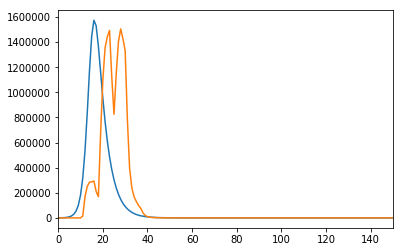

In [112]:
pd.Series(sim_exposed).plot()
#abm_exposed.plot()
abm_exposed.plot()

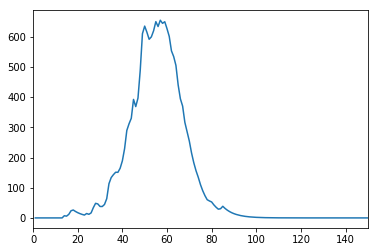

In [51]:
abm_dead.plot()

In [58]:
r_naughts

[49.999666252549545,
 49.999511772662395,
 49.99998020747597,
 49.99999834240266,
 49.99996938449397,
 49.99999165954221]

In [55]:
abm_dead = sim_dead_curve_strain2.diff().ewm(span=10).mean()